In [3]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob

In [4]:
IMG_SIZE = 120
BATCH_SIZE = 16
EPOCHS = 20
DATASET_PATH = "/content/Dataset/data"

In [5]:
def load_images(path, limit=300):
    images = []
    for file in glob.glob(os.path.join(path, "*.jpg"))[:limit]:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 127.5 - 1
        images.append(img)
    return np.array(images)

rgb_images = load_images(DATASET_PATH)
gray_images = np.array([cv2.cvtColor(((img + 1) * 127.5).astype(np.uint8), cv2.COLOR_RGB2GRAY) for img in rgb_images])
gray_images = gray_images.reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 127.5 - 1

#Generator

In [6]:
def build_generator():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = Conv2D(64, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    skips = []
    for f in [128, 256]:
        x = Conv2D(f, 4, strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)
        skips.append(x)

    x = Conv2D(512, 4, strides=2, padding='same')(x)
    x = Dropout(0.3)(x)
    x = ReLU()(x)

    for f, skip in zip([256, 128][::-1], skips[::-1]):
        x = Conv2DTranspose(f, 4, strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        x = ReLU()(x)
        x = Concatenate()([x, skip])

    x = Conv2DTranspose(64, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    out = Conv2DTranspose(3, 3, activation='tanh', padding='same')(x)
    return Model(inputs, out)

#Discriminator

In [7]:
def build_discriminator():
    gray_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    color_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    merged = Concatenate()([gray_input, color_input])

    x = merged
    for f in [64, 128, 256]:
        x = Conv2D(f, 4, strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model([gray_input, color_input], out)


#VGG for perceptual loss

In [8]:
def build_vgg():
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    vgg.trainable = False
    return Model(vgg.input, vgg.get_layer('block2_conv2').output)

In [9]:
generator = build_generator()
discriminator = build_discriminator()
vgg = build_vgg()

# Compile discriminator

In [10]:
discriminator.compile(optimizer=tf.keras.optimizers.Adam(2e-4, 0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Freeze discriminator in combined model

In [11]:
gray_input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
generated_color = generator(gray_input)
discriminator.trainable = False
validity = discriminator([gray_input, generated_color])
features = vgg(generated_color)

combined = Model(gray_input, [validity, features])
combined.compile(optimizer=tf.keras.optimizers.Adam(2e-4, 0.5),
                 loss=['binary_crossentropy', 'mse'],
                 loss_weights=[1.0, 50.0])

# Train

In [12]:
real = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    for i in range(len(gray_images) // BATCH_SIZE):
        idx = np.random.randint(0, gray_images.shape[0], BATCH_SIZE)
        gray_batch = gray_images[idx]
        color_batch = rgb_images[idx]

        gen_imgs = generator.predict(gray_batch)
        d_loss_real = discriminator.train_on_batch([gray_batch, color_batch], real)
        d_loss_fake = discriminator.train_on_batch([gray_batch, gen_imgs], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        vgg_features = vgg.predict(color_batch)
        g_loss = combined.train_on_batch(gray_batch, [real, vgg_features])

    print(f"Epoch {epoch+1}/{EPOCHS} | D Loss: {d_loss[0]:.4f}, Acc: {d_loss[1]:.4f} | G Loss: {g_loss[0]:.4f}")

print("Training done!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━

# Display results

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


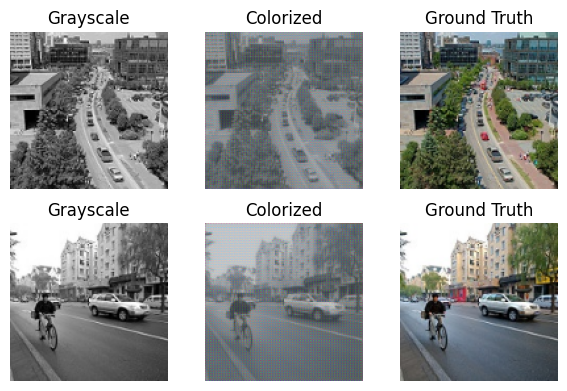

In [13]:
def display_results(generator, gray_images, rgb_images, samples=2):
    idx = np.random.randint(0, gray_images.shape[0], samples)
    gray = gray_images[idx]
    real = rgb_images[idx]
    fake = generator.predict(gray)

    gray = ((gray + 1) * 127.5).astype(np.uint8)
    real = ((real + 1) * 127.5).astype(np.uint8)
    fake = ((fake + 1) * 127.5).astype(np.uint8)

    fig, axes = plt.subplots(samples, 3, figsize=(6, 2 * samples))
    for i in range(samples):
        axes[i, 0].imshow(gray[i].squeeze(), cmap='gray')
        axes[i, 1].imshow(fake[i])
        axes[i, 2].imshow(real[i])
        for j in range(3): axes[i, j].axis('off')
        axes[i, 0].set_title("Grayscale")
        axes[i, 1].set_title("Colorized")
        axes[i, 2].set_title("Ground Truth")
    plt.tight_layout()
    plt.show()

display_results(generator, gray_images, rgb_images)


In [14]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()
import tensorflow as tf
tf.keras.backend.clear_session()

#Conclusion

n this experiment, a Conditional GAN-based approach was implemented for image colorization, transforming grayscale images into their colored counterparts. The model architecture consisted of a U-Net-inspired generator and a PatchGAN discriminator, trained with a combination of adversarial and perceptual losses using features extracted from a pre-trained VGG19 network. By reducing the number of training epochs and introducing dropout layers, the model achieved a balance between performance and training efficiency, mitigating overfitting while preserving important image features. The qualitative results demonstrated that the generator was able to learn plausible color mappings, producing visually realistic colorized images, especially in areas with strong structural cues. This experiment highlights the effectiveness of GANs in generating high-fidelity colorized outputs and underscores the significance of integrating perceptual loss for improved visual quality in deep learning-based image-to-image translation tasks.